In [1]:
import pint.models as model
import pint.toa as toa
import pint.logging
import pint.fitter
from pint.modelutils import model_ecliptic_to_equatorial
import numpy as np
import astropy.units as u
import pint.derived_quantities as dq
import table_utils as tu
from scipy.special import fdtrc

pint.logging.setup(level="ERROR")

1

**J1816+4510 eclipsing calculations**

For J1816+4510, we see additional delays around superior conjuntion at 820 MHz, probably due to additional electron content around the companion that the signal must travel through when the pulsar eclipses. First I want to figure out the DM bump corresponding to this delay (roughly 800 microseconds).

In [9]:
def SC_dDM(dt,freq):
    """ Calculate additional column density at superior conjunction (given additional timing delay)
    
    Parameters
    ==========
    dt: quantity, additional dispersive timing delay due to plasma around companion
    freq: quantity, observing frequency of measured delay
    
    Returns
    =======
    dDM_sup: quantity, additional column density at superior conjunction (cm^-2)
    """
    Dconst = 4.148808e3*(1e6*u.Hz)**2*u.cm**3*u.s*u.pc**-1 # HBOPA, eqn. 4.6
    dDM_sup = (dt*freq**2/Dconst).to(u.pc*u.cm**-3) # extra DM corresponding to delay
    return dDM_sup.to(u.cm**-2)

To compare to a similar calculation in Freire (2005; ASPCS, p. 407), I convert DM (column density) to 1/cm^2. The result is comparable to the column density of J2051-0827 (Stappers et al. 2001).

In [10]:
dDM_1816 = SC_dDM(800.0*1e-6*u.s,820.0*(1e6*u.Hz))
print(dDM_1816)
print(dDM_1816.to(u.pc*u.cm**-3))

4.0007821153349005e+17 1 / cm2
0.12965651820956764 pc / cm3


How big might the companion be based on the duration of the eclipse? Assume inclination angle of 90 deg for now, and consider an eclipse that lasts some fraction of an orbit (based on gap between ingress-egress).

In [11]:
def psr_comp_separation(model,inc=90.0*u.deg,mp=1.4*u.solMass):
    """ Calculate separation between pulsar and binary companion
    
    Parameters
    ==========
    model: object, PINT timing model
    inc: quantity, assumed orbital inclination (optional, default = 90 deg)
    mp: quantity, assumed pulsar mass (optional, default = 1.4 Msun)
    """
    mc = dq.companion_mass(mo['PB'].quantity, mo['A1'].quantity, i=inc, mp=mp)
    return (mo['A1'].quantity/np.sin(inc)).to(u.R_sun)*(1+(mp/mc))

def Rplasma(a, frac_eclipse):
    """ Estimate companion (plasma?) radius based on extent of eclipse
    
    Parameters
    ==========
    a: quantity, separation between the pulsar and companion
    frac_eclipse: float, fraction of the orbit where pulsar signal is obscured
    
    Returns
    =======
    Rplasma: quantity, companion's plasma(?) radius (Solar Radii)
    """
    print(f"Nominal pulsar-companion separation: {a.value:.4f} Rsun")
    ing2sup = frac_eclipse*180.0*u.deg # angle from ingress to superior conjunction
    Rplasma = a*np.sin(ing2sup)
    print(f"Companion's estimated plasma radius: {Rplasma.value:.4f} Rsun ({Rplasma.to(u.km).value:.0f} km)")
    return Rplasma

frac_eclipse = 0.04

par_path = f"data/J1816+4510_eclipseDMX.par"
tim_path = f"data/J1816+4510_eclipseDMX.tim"
mo = model.get_model(par_path)
to = toa.get_TOAs(tim_path,model=mo)
fo = pint.fitter.WLSFitter(to,mo)
x = fo.fit_toas()
a = psr_comp_separation(mo, mp=1.64*u.solMass) # using lower limit on M_psr from Clark et al. (2023)
print(f"J1816+4510 is obscured for {frac_eclipse:.0%} of an orbit...")
rp = Rplasma(a,frac_eclipse)

J1816+4510 is obscured for 4% of an orbit...
Nominal pulsar-companion separation: 2.6041 Rsun
Companion's estimated plasma radius: 0.3264 Rsun (227061 km)


I can use the estimated companion's plasma radius to get some idea of the electron density near the companion (using the additional column density around superior conjunction). This is probably ~order of magnitude.

In [12]:
(dDM_1816/rp).to(u.cm**-3)

<Quantity 17619863.47492632 1 / cm3>

Next, I want to use the equation from Eggleton et al. (1983) to estimate the size of the companion's Roche Lobe, and thus, the path length the pulsar might be encountering around superior conjunction. Do this for a few possible inclination angles and assume pulsar mass is 1.64 solar masses.

In [13]:
def RL_Eggleton(a,mc,mp=1.4*u.solMass):
    """ Calculate Roche Lobe size in solar radii (see Eggleton 1983)
    
    Parameters
    ==========
    a: quantity, separation between the pulsar and companion
    mc: quantity, companion mass (solar masses)
    mp: pulsar mass (default: 1.4 Msun), optional
    
    Returns
    =======
    R_L: quantity, Roche Lobe size (solar radii)
    """
    q = mc/mp
    R_L = 0.49*a*q**(2.0/3)/(0.6*q**(2.0/3)+np.log(1.0+q**(1.0/3)))
    return R_L.to(u.R_sun)

incs = [90.0,85.0,80.0,75.0] # trial inclination angles, degrees

mo = model.get_model(par_path)
to = toa.get_TOAs(tim_path,model=mo)
fo = pint.fitter.WLSFitter(to,mo)
x = fo.fit_toas()

for inc in incs:
    mp = 1.64*u.M_sun
    a = psr_comp_separation(mo,inc=inc*u.deg,mp=mp)
    mc = dq.companion_mass(mo['PB'].quantity, mo['A1'].quantity, i=inc*u.deg, mp=mp)
    R_L = RL_Eggleton(a,mc,mp=mp)
    RlRp_ratio = R_L/rp

    mc_str = f"{mc.value:.4f}"
    q_str = f"{mc/mp:.4f}"
    a_str = f"{a.value:.4f}"
    rl_str = f"{R_L.value:.5f}"
    rlrp_str = f"{RlRp_ratio:.2f}"

    print(f"  i = {inc} deg; mc = {mc_str} Msun; q = {q_str}; a = {a_str} Rsun; RL = {rl_str} Rsun; RL/Rp = {rlrp_str}")

  i = 90.0 deg; mc = 0.1792 Msun; q = 0.1093; a = 2.6041 Rsun; RL = 0.55252 Rsun; RL/Rp = 1.69
  i = 85.0 deg; mc = 0.1800 Msun; q = 0.1097; a = 2.6044 Rsun; RL = 0.55324 Rsun; RL/Rp = 1.70
  i = 80.0 deg; mc = 0.1822 Msun; q = 0.1111; a = 2.6055 Rsun; RL = 0.55544 Rsun; RL/Rp = 1.70
  i = 75.0 deg; mc = 0.1860 Msun; q = 0.1134; a = 2.6073 Rsun; RL = 0.55917 Rsun; RL/Rp = 1.71


Therefore (unlike the systems considered in Freire 2005), the Roche Lobe (R_L above) is somewhat larger than the size of the plasma cloud (R_p), so matter responsible for increased dispersive delays is bound to the companion.

**Optical Constraints Calculations**

I follow a procedure similar to that described in Section 7 of Lynch et al. (2018). For non-WD companions, I include a couple functions to convert magnitude limits to limits on effective temperature, but I'm not sure this is quite good enough since Covey 2007 (where I establish spectral types) doesn't include bolometric corrections.

In [2]:
def MagLim_to_Lum(Mlim):
    """ Convert magnitude limit to luminosity
    
    Parameter
    =========
    Mlim (float): limiting magnitude(s)
    
    Returns
    =======
    Llim (quantity): luminosity limit(s), solar luminosity
    """
    Msun = 4.74
    Llim=u.solLum*10**((Msun-Mlim)/2.5)
    return Llim.decompose()

def TeffLim(Rlim,Llim):
    """ Limit effective temp based on radius, luminosity
    
    Parameters
    ==========
    Rlim (quantity): estimate of stellar radius, solar radii
    Llim (quantity): estimate of stellar luminosity, solar luminosity
    
    Returns
    =======
    Tlim (quantity): upper limit on Teff, Kelvin
    """
    from astropy.units.cds import c
    sbc = 5.6704e-8*u.W*u.meter**-2*u.K**-4
    Tlim=(Llim/(4*np.pi*Rlim**2*sbc))**0.25
    return Tlim.decompose()

In [88]:
# extinction from http://argonaut.skymaps.info (see Green et al. 2015)
# these take distance (largest NE vs. YMW) into account
EBmV_dict = {
    "J0032+6946":0.91,
    "J1239+3239":0.0
}

R_dict = {
    "J0032+6946":0.04*u.Rsun,
    "J1239+3239":0.03*u.Rsun
}

# Read Covey 2007 table (assume spectral classification V - main sequence)
with open('data/covey07.txt') as covey:
    covey_info = covey.readlines()

SpectType_griz_Dict = {}
for ci in covey_info:
    ci_list = ci.strip().split(' ')
    spect_type = ci_list[0]
    MJ = float(ci_list[-1])
    z = float(ci_list[5])+MJ
    i = float(ci_list[4])+z
    r = float(ci_list[3])+i
    g = float(ci_list[2])+r
    #print(f"{spect_type:4s}: {g:.2f}, {r:.2f}, {i:.2f}, {z:.2f}")
    
    SpectType_griz_Dict[spect_type] = [g,r,i,z]

# reddening in PS1 bands from Schlafly & Finkbeiner 2011, Table 6
# grizy
ps1_redden=np.array([3.172,2.271,1.682,1.322,1.087]) # y not constraining?

# assume no detection.  Typical PS1 griz stack limits are:
ps1_lims = np.array([23.3,23.2,23.1,22.3,21.4])

for psr in EBmV_dict.keys():
    par_path = f"data/{psr}_tdb.par"
    mo = model.get_model(par_path)
    
    mp = 1.4*u.M_sun
    mcmed = dq.companion_mass(mo['PB'].quantity, mo['A1'].quantity, i=60.0*u.deg, mp=mp)
    mcmin = dq.companion_mass(mo['PB'].quantity, mo['A1'].quantity, i=90.0*u.deg, mp=mp)
    
    gcoord = mo.coords_as_GAL()
    dmdist_ne, dmdist_ymw = tu.get_dmdists(gcoord,mo['DM'].value)
    
    dmdist = max([dmdist_ne,dmdist_ymw])
    
    distance_mod = 5*np.log10((dmdist*u.kpc/(10.0*u.pc)).decompose())
    
    print(f"{psr}: {mcmin.value:.3f}-{mcmed.value:.3f} Msun")
    griz_lims = ps1_lims-EBmV_dict[psr]*ps1_redden-distance_mod # de-reddened limits
    print(griz_lims)
    
    a = (mo['A1'].quantity * np.sin(60.0*u.deg)).to(u.R_sun) # assume i = 60 deg
    mp = 1.4*u.M_sun
    mc = dq.companion_mass(mo['PB'].quantity, mo['A1'].quantity, i=60.0*u.deg, mp=mp)
#     R_L = RL_Eggleton(a,mc,mp=mp)
#     print(f"Radius (RL) estimate: {R_L}") # why is this important?

    # check griz_lims against SpectType_griz_Dict
    # g=0, r=1, i=2, z=3, y=4
    # g is always the most limiting, so range(1) rather than range(3)
    for band_i in range(1): 
        for stk in SpectType_griz_Dict.keys():
            if griz_lims[band_i] < SpectType_griz_Dict[stk][band_i]:
                print(f"{['g','r','i','z','y'][band_i]} spectral type limit: {stk} ({griz_lims[band_i]}<{SpectType_griz_Dict[stk][band_i]})")
                Tlim = TeffLim(R_dict[psr],MagLim_to_Lum(SpectType_griz_Dict[stk][band_i]))
                print(f"Teff limit?: {Tlim.decompose()}")
                
        
    #print(dmdist,distance_mod)
    #print(f"{psr} {dmdist:.4f} {mo['DM'].value:.4f} {mcmed.value:.4f} {mo['PB'].value:.4f}")

J0032+6946: 0.417-0.496 Msun
[8.15744886 8.87735886 9.31334886 8.84094886 8.15479886]
g spectral type limit: K5 (8.157448863433533<8.290000000000001)
Teff limit?: 12743.716308871619 K
g spectral type limit: K7 (8.157448863433533<8.959999999999999)
Teff limit?: 10921.847165582456 K
g spectral type limit: M0 (8.157448863433533<9.34)
Teff limit?: 10006.820163087528 K
g spectral type limit: M1 (8.157448863433533<9.81)
Teff limit?: 8980.408555745424 K
g spectral type limit: M2 (8.157448863433533<10.36)
Teff limit?: 7912.178837191034 K
g spectral type limit: M2.5 (8.157448863433533<10.940000000000001)
Teff limit?: 6923.028109240033 K
g spectral type limit: M3 (8.157448863433533<11.469999999999999)
Teff limit?: 6127.680246786012 K
g spectral type limit: M4 (8.157448863433533<12.37)
Teff limit?: 4980.765497883628 K
g spectral type limit: M5 (8.157448863433533<13.61)
Teff limit?: 3743.657377945321 K
g spectral type limit: M6 (8.157448863433533<15.110000000000001)
Teff limit?: 2650.3064588949637

I think the issue with temperature constraints reported here for M-stars is that they're based on band-specific magnitude to luminosity limits. What I want to do instead is, once I've determined the correct band/spectral type to do the limiting, use the bolometric correction (??) to convert the band-limiting (g-band across the board it looks like) magnitude to a bolometric magnitude, convert to luminosity, and THEN set a Teff limit with R_L. For now, I'll just grab estimates for Teff from the web associated with M6, M5, M3, M1. These limits and spectral types assume main sequence stars (V) so I think all of this is already really uncertain.

Teff for M6 = 3100 K, M5 = 3200 K, M3 = 3500 K, M1 = 3700 K.
Grabbed these from https://sites.uni.edu/morgans/astro/course/Notes/section2/spectraltemps.html

J0032+6946: using values for 0.49562111 Msun, cooling age 37.9 Myr: 54954 K
J1239+3239: using values for 0.14661164 Msun, cooling age 1450.5 Myr: 8511 K


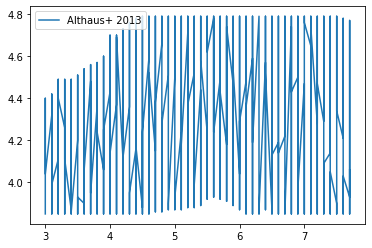

In [84]:
import matplotlib.pyplot as plt
from astropy.units import cds

#m = 0.4956
ms = [0.4956, 0.1467]
psrs = ["J0032+6946", "J1239+3239"]
rs = [0.003, 0.004]

# read in Althaus 2013 table (http://cdsarc.u-strasbg.fr/viz-bin/qcat?J/A+A/557/A19#/browse)
althausdata = np.loadtxt('data/althaus+13.dat',delimiter="|")
logteffs = althausdata[:,0] # log effective temperature [K]
loggs    = althausdata[:,1] # log surface gravity [cm/s^2]
masses   = althausdata[:,2] # WD mass [Msun]
cooling_ages     = althausdata[:,4] # WD age [Myr]

for m,psr in zip(ms,psrs):

    idx = (np.abs(masses - m)).argmin()
    
    teff, mass, age = 10**logteffs[idx], masses[idx], ages[idx]

    radius=((cds.G*mass*u.solMass/(g*u.cm/u.s**2))**0.5).to(u.Rsun).value
    
    print(f"{psr}: using values for {mass} Msun, cooling age {age:.1f} Myr: {teff:0.0f} K")
    
# sort_inds = np.argsort(loggs)
# plt.plot(loggs[sort_inds],logteffs[sort_inds],label='Althaus+ 2013')
# plt.legend()

# plt.plot(np.log10(r_m.value),teff_i16[inds]*1e3,label='Istrate 2016')
# plt.plot(np.log10(ber_radii_m),bteff,label='Bergeron 2011')
# plt.legend()

In [75]:
for m,age in zip(masses,ages):
    short_m = f"{m:0.3f}"
    if short_m == "0.147":
        print(m,age)

0.14661164 1450.54334285
0.14689009 1524.94422941


In [24]:
# Implement Mamajek values instead (include BC, but how to get griz from colors provided?)
with open('data/mamajek.txt') as mamajek:
    mj_data = mamajek.readlines()

In [25]:
for mj in mj_data:
    if mj.startswith("#"):
        continue
    print(mj)

O3V    44900 4.652 -4.01   5.82  -9.81 13.43   -5.80 -0.330  ...    ...    ...    ...    ...    ..... -1.175  ...    .....  .....  .....  .....  ....   ....   ...     ...    ...    ...     ...   ...  ...  59    O3V   

O4V    42900 4.632 -3.89   5.65  -9.39 12.13   -5.50 -0.326  ...    ...    ...    ...    ...    ..... -1.160  ...    .....  .....  .....  .....  ....   ....   ...     ...    ...    ...     ...   ...  ...  48    O4V   

O5V    41400 4.617 -3.76   5.54  -9.11 11.45   -5.35 -0.323  ...    ...    ...    ...    ...   -0.133 -1.150  ...    .....  .....  .....  .....  ....   ....   ...     ...    ...    ...    -0.620 ...  ...  43    O5V   

O5.5V  40500 4.607 -3.67   5.44  -8.87 10.71   -5.20 -0.322  ...    ...    ...    ...    ...   -0.133 -1.145  ...    .....  .....  .....  .....  ....   ....   ...     ...    ...    ...    -0.620 ...  ...  38    O5.5V 

O6V    39500 4.597 -3.57   5.36  -8.67 10.27   -5.10 -0.321  ...    ...    ...    ...    ...   -0.132 -1.140  ...    .....  

F-tests for parameter inclusion in timing solutions.

Subscripts "1" are without the parameter in question, "2" includes the parameter.

In [3]:
def ftest(chi2_1, chi2_2, dof_1, dof_2):
    delta_chi2 = chi2_1 - chi2_2
    delta_dof = dof_1 - dof_2
    redchi2_2 = chi2_2 / dof_2
    F = float((delta_chi2 / delta_dof) / redchi2_2) # F-statistic
    ft = fdtrc(delta_dof, dof_2, F) # probability of null hypothesis (?)
    return ft

F-test for PSR J0636+5128 PX.

In [4]:
chi2_1 = 1836.87
chi2_2 = 1834.81
dof_1 = 1403-50
dof_2 = 1403-51
ft = ftest(chi2_1, chi2_2, dof_1, dof_2)
print(ft)

0.21814667466085338


We want this to be below ~0.0027 or so. PX is not significant for J0636.

F-test for PSR J1816+4510 F2

In [ ]:
chi2_1 = 2047.67
chi2_2 = 1829.15
dof_1 = 749-15
dof_2 = 749-16
ft = ftest(chi2_1, chi2_2, dof_1, dof_2)
print(ft)

\< 0.0027; F2 is significant for J1816.

F-test for PSR J1816+4510 FB1 (adding to F2)

In [ ]:
chi2_1 = 1829.15
chi2_2 = 1800.46
dof_1 = 749-16
dof_2 = 749-17
ft = ftest(chi2_1, chi2_2, dof_1, dof_2)
print(ft)

\< 0.0027; FB1 is significant for J1816 when F2 is fit beforehand (it's not when fit by itself).

F-test for PSR J1816+4510 FB2 (adding to F2+FB1)

In [ ]:
chi2_1 = 1800.46
chi2_2 = 1786.65
dof_1 = 749-17
dof_2 = 749-18
ft = ftest(chi2_1, chi2_2, dof_1, dof_2)
print(ft)

\> 0.0027; FB2 is not significant for J1816.

F-test for PSR J1816+4510 XDOT (adding to F2+FB1)

In [ ]:
chi2_1 = 1800.46
chi2_2 = 1789.12
dof_1 = 749-17
dof_2 = 749-18
ft = ftest(chi2_1, chi2_2, dof_1, dof_2)
print(ft)

\> 0.0027; XDOT is not significant for J1816.

F-test for PSR J1816+4510 XDOT (adding to F2 only)

In [ ]:
chi2_1 = 1829.15
chi2_2 = 1820.37
dof_1 = 749-16
dof_2 = 749-17
ft = ftest(chi2_1, chi2_2, dof_1, dof_2)
print(ft)

\> 0.0027; XDOT is not significant for J1816.

F-test for PSR J1816+4510 XDOT (only extra parameter, no F2 or FB1)

In [ ]:
chi2_1 = 2047.67
chi2_2 = 1975.85
dof_1 = 749-15
dof_2 = 749-16
ft = ftest(chi2_1, chi2_2, dof_1, dof_2)
print(ft)

\> 0.0027; XDOT is significant for J1816.

F-test for PSR J1816+4510 F3 (adding to F2)

In [ ]:
chi2_1 = 1829.15
chi2_2 = 1820.94
dof_1 = 749-16
dof_2 = 749-17
ft = ftest(chi2_1, chi2_2, dof_1, dof_2)
print(ft)

\> 0.0027; XDOT is significant for J1816.

F-test for PSR J1239+3239 PMDEC

In [ ]:
chi2_1 = 346.7
chi2_2 = 339.07
dof_1 = 283-12
dof_2 = 283-13
ft = ftest(chi2_1, chi2_2, dof_1, dof_2)
print(ft)

We want this to be below ~0.0027 or so. PMDEC is not significant for J1239.

F-test for PSR J1239+3239 PBDOT

In [ ]:
chi2_1 = 346.7
chi2_2 = 341.23
dof_1 = 283-12
dof_2 = 283-13
ft = ftest(chi2_1, chi2_2, dof_1, dof_2)
print(ft)

We want this to be below ~0.0027 or so. PBDOT is not significant for J1239.

F-test for PSR J1239+3239 PMDEC & PBDOT

In [ ]:
chi2_1 = 346.7
chi2_2 = 332.17
dof_1 = 283-12
dof_2 = 283-14
ft = ftest(chi2_1, chi2_2, dof_1, dof_2)
print(ft)

We want this to be below ~0.0027 or so. It's closer, but PMDEC and PBDOT are not significant for J1239.

F-test for PSR J1327+3423 PX

In [6]:
chi2_1 = 2131.91
chi2_2 = 2116.83
dof_1 = 1575-47
dof_2 = 1575-48
ft = ftest(chi2_1, chi2_2, dof_1, dof_2)
print(ft)

0.000995443012847512


This is < 0.0027. PX is significant for PSR J1327+3423.

F-test for PSR J1816+4510 F2 (with DMX)

In [10]:
chi2_1 = 1137.24
chi2_2 = 1131.08
dof_1 = 749-81
dof_2 = 749-82
ft = ftest(chi2_1, chi2_2, dof_1, dof_2)
print(ft)

0.057089071613551


This is > 0.0027. With DMX, F2 is not significant for PSR J1816+4510.

F-test for PSR J1816+4510 FB1 (with DMX)

In [11]:
chi2_1 = 1137.24
chi2_2 = 1132.1
dof_1 = 749-81
dof_2 = 749-82
ft = ftest(chi2_1, chi2_2, dof_1, dof_2)
print(ft)

0.08228305805880497


This is > 0.0027. With DMX, FB1 is not significant for PSR J1816+4510.